In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import cv2
from pathlib import Path

In [2]:
from utils.utils import DATA_SET

ds_name = DATA_SET[3]
root = Path.cwd()
wd = root / ('data/train/' + ds_name)
img_dir = wd / '02'
seg_dir = wd / '02_ST/SEG'
tra_dir = wd / '02_GT/TRA'

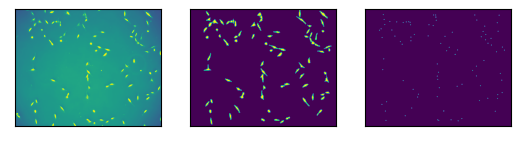

In [3]:
img_name = random.choice([f for f in img_dir.glob('*')])
seg_name = seg_dir / ('man_seg' + img_name.name[1:])
tra_name = tra_dir / ('man_track' + img_name.name[1:])
img = tifffile.imread(str(img_name))
seg = tifffile.imread(str(seg_name))
tra = tifffile.imread(str(tra_name))
seg_bin = 255 * np.uint8(seg > 0)
tra_bin = 255 * np.uint8(tra > 0)
# cv2.imshow('image', np.hstack((img, 255 * (mask / mask.max()))))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
im_list = [img, seg_bin, tra_bin]
fig, axs = plt.subplots(1, len(im_list))
for i in range(len(im_list)):
    axs[i].imshow(im_list[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

In [4]:
def stat(im):
    s = pd.Series(np.bincount(im.flatten()))
    return s[s != 0]
stat(tra)

0      413910
698         9
699         9
707         9
708         9
        ...  
958         9
959         9
960         9
967         9
968         9
Length: 90, dtype: int64

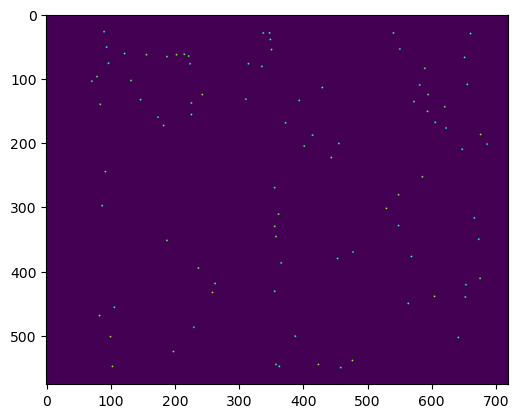

In [5]:
cnts, hier = cv2.findContours(tra_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
det_bin = np.zeros_like(tra_bin)
for i in range(len(cnts)):
    M = cv2.moments(cnts[i])
    cx, cy = int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])
    cv2.circle(det_bin, (cx, cy), 1, 255, -1)
plt.imshow(det_bin)
plt.show()

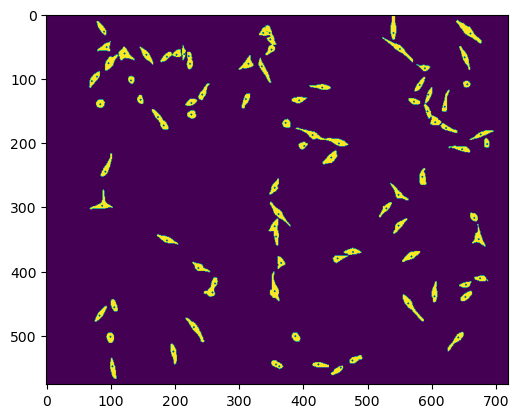

In [6]:
diff = cv2.absdiff(seg_bin, det_bin)
plt.imshow(diff)
plt.show()

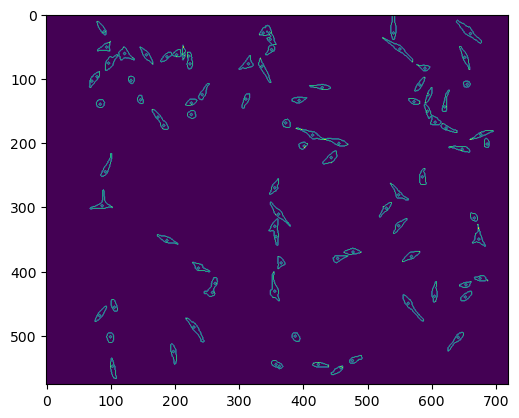

In [7]:
cnts, hier = cv2.findContours(diff, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
res = np.zeros_like(diff)
cv2.drawContours(res, cnts, -1, 255, 1)
plt.imshow(res)
plt.show()

In [8]:
hier = np.squeeze(hier)
hier

array([[  2,  -1,   1,  -1],
       [ -1,  -1,  -1,   0],
       [  4,   0,   3,  -1],
       [ -1,  -1,  -1,   2],
       [  7,   2,   5,  -1],
       [  6,  -1,  -1,   4],
       [ -1,   5,  -1,   4],
       [  9,   4,   8,  -1],
       [ -1,  -1,  -1,   7],
       [ 11,   7,  10,  -1],
       [ -1,  -1,  -1,   9],
       [ 13,   9,  12,  -1],
       [ -1,  -1,  -1,  11],
       [ 15,  11,  14,  -1],
       [ -1,  -1,  -1,  13],
       [ 17,  13,  16,  -1],
       [ -1,  -1,  -1,  15],
       [ 19,  15,  18,  -1],
       [ -1,  -1,  -1,  17],
       [ 21,  17,  20,  -1],
       [ -1,  -1,  -1,  19],
       [ 23,  19,  22,  -1],
       [ -1,  -1,  -1,  21],
       [ 25,  21,  24,  -1],
       [ -1,  -1,  -1,  23],
       [ 27,  23,  26,  -1],
       [ -1,  -1,  -1,  25],
       [ 29,  25,  28,  -1],
       [ -1,  -1,  -1,  27],
       [ 31,  27,  30,  -1],
       [ -1,  -1,  -1,  29],
       [ 33,  29,  32,  -1],
       [ -1,  -1,  -1,  31],
       [ 36,  31,  34,  -1],
       [ 35,  

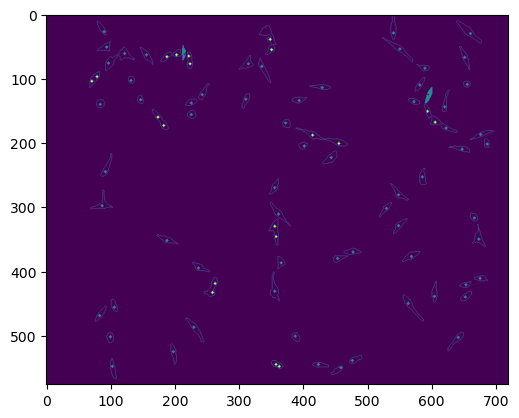

In [9]:
det_mask = np.zeros_like(diff)
seg_mask = np.zeros_like(diff)
for i in range(len(cnts)):
    first_child = hier[i, -2]
    parent = hier[i, -1]
    if first_child != -1:
        next_child = hier[first_child, 0]
        if next_child != -1:
            cv2.drawContours(det_mask, cnts, first_child, 255, -1)
            cv2.drawContours(det_mask, cnts, next_child, 255, -1)

            cv2.drawContours(seg_mask, cnts, i, 255, -1)
        else:
            cv2.drawContours(det_mask, cnts, first_child, 127, -1)

            cv2.drawContours(seg_mask, cnts, i, 127, -1)
        cv2.drawContours(det_mask, cnts, i, 50, 1)
    elif parent == -1:
        cv2.drawContours(det_mask, cnts, i, 127, -1)
plt.imshow(det_mask)
plt.show()

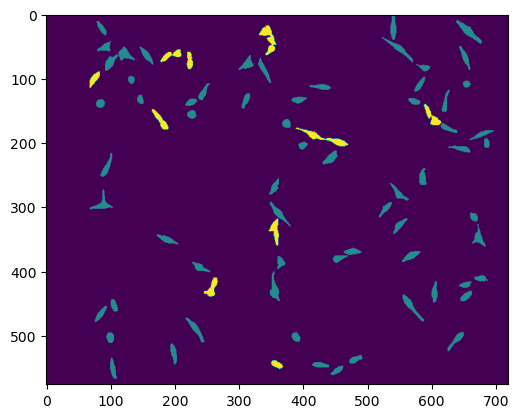

In [10]:
plt.imshow(seg_mask)
plt.show()

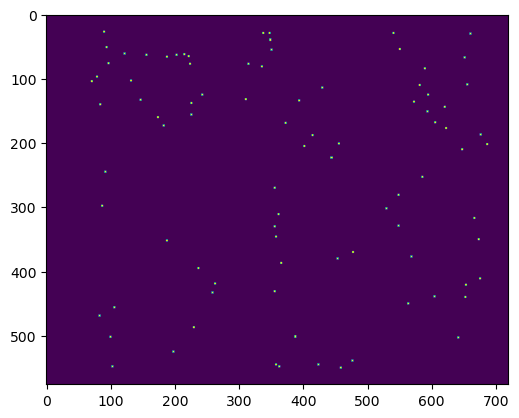

In [11]:
from utils.data_loading import CTCDataset

mask = np.stack((seg, tra), axis=-1)
mask_pred = CTCDataset.preprocess(mask, -1, is_mask=True)
seg_mask, det_mask = mask_pred[0, ...], mask_pred[1, ...]
plt.imshow(det_mask)
plt.show()

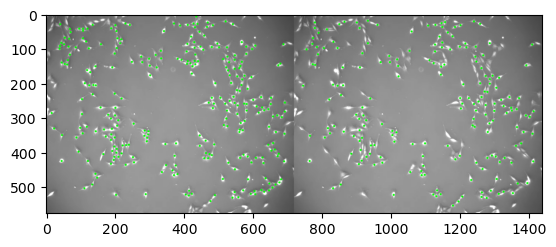

In [12]:
pred = cv2.imread(str(root / 'pred.bmp'), -1)
plt.imshow(pred)
plt.show()